In [1]:
import pandas as pd
import numpy as np 
import re
import gc
import time 

from collections import Counter
from contextlib import contextmanager
from lightgbm import LGBMClassifier

import imblearn
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve, auc, classification_report, make_scorer
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score, train_test_split,GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

from collections import Counter

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [12]:
import shap

In [177]:
#pip install evidently

  Created wheel for umap-learn: filename=umap_learn-0.5.3-py3-none-any.whl size=82829 sha256=f4f21ae33a0b08000217eb29df388aa21f13e1fd02ca18502d8d771bd37228cb
  Stored in directory: c:\users\gogeo_laptop1\appdata\local\pip\cache\wheels\f4\3e\1c\596d0a463d17475af648688443fa4846fef624d1390339e7e9
  Created wheel for pynndescent: filename=pynndescent-0.5.10-py3-none-any.whl size=55638 sha256=df2a826c685f5aca01ab6876c8514661ba44baeaf45764c0c0d6c488597eff07
  Stored in directory: c:\users\gogeo_laptop1\appdata\local\pip\cache\wheels\12\f9\4d\ec5ad1c823c710fcc4473669fdcffc8891f4bc398c841af22e
Successfully built umap-learn pynndescent
  Attempting uninstall: typing-extensions
    Found existing installation: typing-extensions 4.1.1
    Uninstalling typing-extensions-4.1.1:
      Successfully uninstalled typing-extensions-4.1.1
Note: you may need to restart the kernel to use updated packages.


# Exploration des données

In [6]:
def one_hot_encoder(df, nan_as_category = True):
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns= categorical_columns, dummy_na= nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns

In [7]:
def application_train_test(num_rows = None, nan_as_category = False):
    # Lecture de la dataset
    df = pd.read_csv(r"D:/Openclassrooms/Projets/projet 07/Data/unzipped_data/application_train.csv", nrows= num_rows)
    print("Train samples: {}".format(len(df)))
    # Retrait des caractères spéciaux des noms
    df = df.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
    
    # Retrait de 4 applications dont le code du sex est XNA
    df = df[df['CODE_GENDER'] != 'XNA']
    
    # Catégorisation de 3 features ayant 2 catégories en binaire (0 où 1)
    for bin_feature in ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']:
        df[bin_feature], uniques = pd.factorize(df[bin_feature])
        
    # Gestion des variables catégoriques par One Hot Encoding
    df, cat_cols = one_hot_encoder(df, nan_as_category)
        
    # Remplacement des valeurs de days_employed = 365243 par NaN
    df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace= True)
    # Création de ratio
    df['DAYS_EMPLOYED_PERC'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
    df['INCOME_CREDIT_PERC'] = df['AMT_INCOME_TOTAL'] / df['AMT_CREDIT']
    df['INCOME_PER_PERSON'] = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS']
    df['ANNUITY_INCOME_PERC'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
    df['PAYMENT_RATE'] = df['AMT_ANNUITY'] / df['AMT_CREDIT']
    
    return df

In [8]:
num_rows = None 
df = application_train_test(num_rows)

Train samples: 307511


In [9]:
df.head()

,SK_ID_CURR,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes,DAYS_EMPLOYED_PERC,INCOME_CREDIT_PERC,INCOME_PER_PERSON,ANNUITY_INCOME_PERC,PAYMENT_RATE
0,100002,1,0,0,0,0,202500.0,406597.5,24700.5,351000.0,...,0,1,0,1,0,0.067329,0.498036,202500.0,0.121978,0.060749
1,100003,0,1,0,1,0,270000.0,1293502.5,35698.5,1129500.0,...,0,0,0,1,0,0.070862,0.208736,135000.0,0.132217,0.027598
2,100004,0,0,1,0,0,67500.0,135000.0,6750.0,135000.0,...,0,0,0,0,0,0.011814,0.500000,67500.0,0.100000,0.050000
3,100006,0,1,0,0,0,135000.0,312682.5,29686.5,297000.0,...,0,0,0,0,0,0.159905,0.431748,67500.0,0.219900,0.094941
4,100007,0,0,0,0,0,121500.0,513000.0,21865.5,513000.0,...,0,0,0,0,0,0.152418,0.236842,121500.0,0.179963,0.042623


In [10]:
# Vérification de l'unicité des ID
df.duplicated(subset=['SK_ID_CURR']).value_counts()

False    307507
dtype: int64

In [11]:
# Vérification des variables catégorielles
c = (df.dtypes == 'object').value_counts()
c

False    247
dtype: int64

In [12]:
df.TARGET.value_counts()

0    282682
1     24825
Name: TARGET, dtype: int64

In [13]:
counts = df['TARGET'].value_counts()  # Comptage des valeurs
(counts / counts.sum()) * 100 

0    91.927013
1     8.072987
Name: TARGET, dtype: float64

La target est déséquilibrée avec seulement 8.07 % de risque de non remboursement

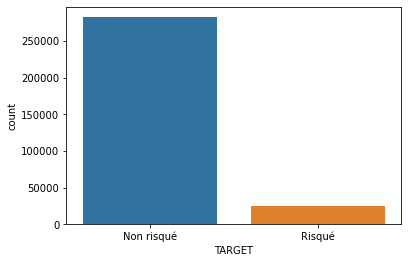

In [14]:
g = sns.countplot(df['TARGET'])
g.set_xticklabels(['Non risqué', 'Risqué'])
plt.show()

## Merge des différentes tables

### bureau et bureau_balance

In [15]:
def bureau_and_balance(num_rows = None, nan_as_category = True):
    bureau = pd.read_csv(r"D:/Openclassrooms/Projets/projet 07/Data/unzipped_data/bureau.csv", nrows = num_rows)
    bb = pd.read_csv(r"D:/Openclassrooms/Projets/projet 07/Data/unzipped_data/bureau_balance.csv", nrows = num_rows)
    bureau = bureau.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
    bb = bb.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
    bb, bb_cat = one_hot_encoder(bb, nan_as_category)
    bureau, bureau_cat = one_hot_encoder(bureau, nan_as_category)
    
    #  aggregations et merge avec bureau.csv
    bb_aggregations = {'MONTHS_BALANCE': ['min', 'max', 'size']}
    for col in bb_cat:
        bb_aggregations[col] = ['mean']
    bb_agg = bb.groupby('SK_ID_BUREAU').agg(bb_aggregations)
    bb_agg.columns = pd.Index([e[0] + "_" + e[1].upper() for e in bb_agg.columns.tolist()])
    bureau = bureau.join(bb_agg, how='left', on='SK_ID_BUREAU')
    bureau.drop(['SK_ID_BUREAU'], axis=1, inplace= True)
    del bb, bb_agg
    gc.collect()
    
    # features numériques
    num_aggregations = {
        'DAYS_CREDIT': ['min', 'max', 'mean', 'var'],
        'DAYS_CREDIT_ENDDATE': ['min', 'max', 'mean'],
        'DAYS_CREDIT_UPDATE': ['mean'],
        'CREDIT_DAY_OVERDUE': ['max', 'mean'],
        'AMT_CREDIT_MAX_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM_LIMIT': ['mean', 'sum'],
        'AMT_ANNUITY': ['max', 'mean'],
        'CNT_CREDIT_PROLONG': ['sum'],
        'MONTHS_BALANCE_MIN': ['min'],
        'MONTHS_BALANCE_MAX': ['max'],
        'MONTHS_BALANCE_SIZE': ['mean', 'sum']
    }
    #  features catégoriques
    cat_aggregations = {}
    for cat in bureau_cat: cat_aggregations[cat] = ['mean']
    for cat in bb_cat: cat_aggregations[cat + "_MEAN"] = ['mean']
    
    bureau_agg = bureau.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    bureau_agg.columns = pd.Index(['BURO_' + e[0] + "_" + e[1].upper() for e in bureau_agg.columns.tolist()])
    
    # Bureau: Active credits - using only numerical aggregations
    active = bureau[bureau['CREDIT_ACTIVE_Active'] == 1]
    active_agg = active.groupby('SK_ID_CURR').agg(num_aggregations)
    active_agg.columns = pd.Index(['ACTIVE_' + e[0] + "_" + e[1].upper() for e in active_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(active_agg, how='left', on='SK_ID_CURR')
    del active, active_agg
    gc.collect()
    # Bureau: Closed credits - using only numerical aggregations
    closed = bureau[bureau['CREDIT_ACTIVE_Closed'] == 1]
    closed_agg = closed.groupby('SK_ID_CURR').agg(num_aggregations)
    closed_agg.columns = pd.Index(['CLOSED_' + e[0] + "_" + e[1].upper() for e in closed_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(closed_agg, how='left', on='SK_ID_CURR')
    del closed, closed_agg, bureau
    gc.collect()
    return bureau_agg

### Previous_applications

In [16]:
# Preprocess previous_applications.csv
def previous_applications(num_rows = None, nan_as_category = True):
    prev = pd.read_csv(r"D:/Openclassrooms/Projets/projet 07/Data/unzipped_data/previous_application.csv", nrows = num_rows)
    prev = prev.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
    prev, cat_cols = one_hot_encoder(prev, nan_as_category= True)
    # Days 365.243 values -> nan
    prev['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace= True)
    prev['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_TERMINATION'].replace(365243, np.nan, inplace= True)
    # Add feature: value ask / value received percentage
    prev['APP_CREDIT_PERC'] = prev['AMT_APPLICATION'] / prev['AMT_CREDIT']
    # Previous applications numeric features
    num_aggregations = {
        'AMT_ANNUITY': ['min', 'max', 'mean'],
        'AMT_APPLICATION': ['min', 'max', 'mean'],
        'AMT_CREDIT': ['min', 'max', 'mean'],
        'APP_CREDIT_PERC': ['min', 'max', 'mean', 'var'],
        'AMT_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'AMT_GOODS_PRICE': ['min', 'max', 'mean'],
        'HOUR_APPR_PROCESS_START': ['min', 'max', 'mean'],
        'RATE_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'DAYS_DECISION': ['min', 'max', 'mean'],
        'CNT_PAYMENT': ['mean', 'sum'],
    }
    # Previous applications categorical features
    cat_aggregations = {}
    for cat in cat_cols:
        cat_aggregations[cat] = ['mean']
    
    prev_agg = prev.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    prev_agg.columns = pd.Index(['PREV_' + e[0] + "_" + e[1].upper() for e in prev_agg.columns.tolist()])
    # Previous Applications: Approved Applications - only numerical features
    approved = prev[prev['NAME_CONTRACT_STATUS_Approved'] == 1]
    approved_agg = approved.groupby('SK_ID_CURR').agg(num_aggregations)
    approved_agg.columns = pd.Index(['APPROVED_' + e[0] + "_" + e[1].upper() for e in approved_agg.columns.tolist()])
    prev_agg = prev_agg.join(approved_agg, how='left', on='SK_ID_CURR')
    # Previous Applications: Refused Applications - only numerical features
    refused = prev[prev['NAME_CONTRACT_STATUS_Refused'] == 1]
    refused_agg = refused.groupby('SK_ID_CURR').agg(num_aggregations)
    refused_agg.columns = pd.Index(['REFUSED_' + e[0] + "_" + e[1].upper() for e in refused_agg.columns.tolist()])
    prev_agg = prev_agg.join(refused_agg, how='left', on='SK_ID_CURR')
    del refused, refused_agg, approved, approved_agg, prev
    gc.collect()
    return prev_agg

### POS_CASH_balance

In [17]:
# Preprocess POS_CASH_balance.csv
def pos_cash(num_rows = None, nan_as_category = True):
    pos = pd.read_csv(r"D:/Openclassrooms/Projets/projet 07/Data/unzipped_data/POS_CASH_balance.csv", nrows = num_rows)
    pos = pos.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
    pos, cat_cols = one_hot_encoder(pos, nan_as_category= True)
    # Features
    aggregations = {
        'MONTHS_BALANCE': ['max', 'mean', 'size'],
        'SK_DPD': ['max', 'mean'],
        'SK_DPD_DEF': ['max', 'mean']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    
    pos_agg = pos.groupby('SK_ID_CURR').agg(aggregations)
    pos_agg.columns = pd.Index(['POS_' + e[0] + "_" + e[1].upper() for e in pos_agg.columns.tolist()])
    # Count pos cash accounts
    pos_agg['POS_COUNT'] = pos.groupby('SK_ID_CURR').size()
    del pos
    gc.collect()
    return pos_agg
    
# Preprocess installments_payments.csv
def installments_payments(num_rows = None, nan_as_category = True):
    ins = pd.read_csv(r"D:/Openclassrooms/Projets/projet 07/Data/unzipped_data/installments_payments.csv", nrows = num_rows)
    ins = ins.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
    ins, cat_cols = one_hot_encoder(ins, nan_as_category= True)
    # Percentage and difference paid in each installment (amount paid and installment value)
    ins['PAYMENT_PERC'] = ins['AMT_PAYMENT'] / ins['AMT_INSTALMENT']
    ins['PAYMENT_DIFF'] = ins['AMT_INSTALMENT'] - ins['AMT_PAYMENT']
    # Days past due and days before due (no negative values)
    ins['DPD'] = ins['DAYS_ENTRY_PAYMENT'] - ins['DAYS_INSTALMENT']
    ins['DBD'] = ins['DAYS_INSTALMENT'] - ins['DAYS_ENTRY_PAYMENT']
    ins['DPD'] = ins['DPD'].apply(lambda x: x if x > 0 else 0)
    ins['DBD'] = ins['DBD'].apply(lambda x: x if x > 0 else 0)
    # Features: Perform aggregations
    aggregations = {
        'NUM_INSTALMENT_VERSION': ['nunique'],
        'DPD': ['max', 'mean', 'sum'],
        'DBD': ['max', 'mean', 'sum'],
        'PAYMENT_PERC': ['max', 'mean', 'sum', 'var'],
        'PAYMENT_DIFF': ['max', 'mean', 'sum', 'var'],
        'AMT_INSTALMENT': ['max', 'mean', 'sum'],
        'AMT_PAYMENT': ['min', 'max', 'mean', 'sum'],
        'DAYS_ENTRY_PAYMENT': ['max', 'mean', 'sum']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    ins_agg = ins.groupby('SK_ID_CURR').agg(aggregations)
    ins_agg.columns = pd.Index(['INSTAL_' + e[0] + "_" + e[1].upper() for e in ins_agg.columns.tolist()])
    # Count installments accounts
    ins_agg['INSTAL_COUNT'] = ins.groupby('SK_ID_CURR').size()
    del ins
    gc.collect()
    return ins_agg

### credit_card_balance

In [18]:
# Preprocess credit_card_balance.csv
def credit_card_balance(num_rows = None, nan_as_category = True):
    cc = pd.read_csv(r"D:/Openclassrooms/Projets/projet 07/Data/unzipped_data/credit_card_balance.csv", nrows = num_rows)
    cc = cc.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
    cc, cat_cols = one_hot_encoder(cc, nan_as_category= True)
    # General aggregations
    cc.drop(['SK_ID_PREV'], axis= 1, inplace = True)
    cc_agg = cc.groupby('SK_ID_CURR').agg(['min', 'max', 'mean', 'sum', 'var'])
    cc_agg.columns = pd.Index(['CC_' + e[0] + "_" + e[1].upper() for e in cc_agg.columns.tolist()])
    # Count credit card lines
    cc_agg['CC_COUNT'] = cc.groupby('SK_ID_CURR').size()
    del cc
    gc.collect()
    return cc_agg

### Merging data

In [19]:
bureau = bureau_and_balance(num_rows)
print("Bureau df shape:", bureau.shape)
df = df.join(bureau, how='left', on='SK_ID_CURR')
del bureau
gc.collect()

prev = previous_applications(num_rows)
print("Previous applications df shape:", prev.shape)
df = df.join(prev, how='left', on='SK_ID_CURR')
del prev
gc.collect()

pos = pos_cash(num_rows)
print("Pos-cash balance df shape:", pos.shape)
df = df.join(pos, how='left', on='SK_ID_CURR')
del pos
gc.collect()

ins = installments_payments(num_rows)
print("Installments payments df shape:", ins.shape)
df = df.join(ins, how='left', on='SK_ID_CURR')
del ins
gc.collect()

cc = credit_card_balance(num_rows)
print("Credit card balance df shape:", cc.shape)
df = df.join(cc, how='left', on='SK_ID_CURR')
del cc
gc.collect()


Bureau df shape: (305811, 116)
Previous applications df shape: (338857, 249)
Pos-cash balance df shape: (337252, 18)
Installments payments df shape: (339587, 26)
Credit card balance df shape: (103558, 141)


0

In [20]:
df.shape

(307507, 797)

In [21]:
# Verification des duplicats d'ID après merge et aggregation
df.duplicated(subset=['SK_ID_CURR']).value_counts()

False    307507
dtype: int64

### Gestion des NaN

In [22]:
df.isna().mean()

SK_ID_CURR                          0.000000
TARGET                              0.000000
CODE_GENDER                         0.000000
FLAG_OWN_CAR                        0.000000
FLAG_OWN_REALTY                     0.000000
                                      ...   
CC_NAME_CONTRACT_STATUS_nan_MAX     0.717389
CC_NAME_CONTRACT_STATUS_nan_MEAN    0.717389
CC_NAME_CONTRACT_STATUS_nan_SUM     0.717389
CC_NAME_CONTRACT_STATUS_nan_VAR     0.719444
CC_COUNT                            0.717389
Length: 797, dtype: float64

In [23]:
# Suppression des features ayant plus de 60% de valeurs nulles
df2 = df.copy()
del df
gc.collect()
perc = 60.0
min_count =  int(((100-perc)/100)*df2.shape[0] + 1)
df2.dropna(axis=1,
           thresh=min_count,
           inplace = True)

In [24]:
columns = df2.columns
for col in columns:
    if df2[col].isnull().values.any():
        df2[col].fillna(value=df2[col].median(), inplace =True)

In [25]:
df2.isna().sum()

SK_ID_CURR                        0
TARGET                            0
CODE_GENDER                       0
FLAG_OWN_CAR                      0
FLAG_OWN_REALTY                   0
                                 ..
INSTAL_AMT_PAYMENT_SUM            0
INSTAL_DAYS_ENTRY_PAYMENT_MAX     0
INSTAL_DAYS_ENTRY_PAYMENT_MEAN    0
INSTAL_DAYS_ENTRY_PAYMENT_SUM     0
INSTAL_COUNT                      0
Length: 585, dtype: int64

In [26]:
# Transformation de la colonne ID en colonne d'index
df2.set_index('SK_ID_CURR',inplace=True)


In [27]:
df2

,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,...,INSTAL_AMT_INSTALMENT_MEAN,INSTAL_AMT_INSTALMENT_SUM,INSTAL_AMT_PAYMENT_MIN,INSTAL_AMT_PAYMENT_MAX,INSTAL_AMT_PAYMENT_MEAN,INSTAL_AMT_PAYMENT_SUM,INSTAL_DAYS_ENTRY_PAYMENT_MAX,INSTAL_DAYS_ENTRY_PAYMENT_MEAN,INSTAL_DAYS_ENTRY_PAYMENT_SUM,INSTAL_COUNT
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100002,1,0,0,0,0,202500.0,406597.5,24700.5,351000.0,0.018801,...,11559.247105,219625.695,9251.775,53093.745,11559.247105,219625.695,-49.0,-315.421053,-5993.0,19.0
100003,0,1,0,1,0,270000.0,1293502.5,35698.5,1129500.0,0.003541,...,64754.586000,1618864.650,6662.970,560835.360,64754.586000,1618864.650,-544.0,-1385.320000,-34633.0,25.0
100004,0,0,1,0,0,67500.0,135000.0,6750.0,135000.0,0.010032,...,7096.155000,21288.465,5357.250,10573.965,7096.155000,21288.465,-727.0,-761.666667,-2285.0,3.0
100006,0,1,0,0,0,135000.0,312682.5,29686.5,297000.0,0.008019,...,62947.088438,1007153.415,2482.920,691786.890,62947.088438,1007153.415,-12.0,-271.625000,-4346.0,16.0
100007,0,0,0,0,0,121500.0,513000.0,21865.5,513000.0,0.028663,...,12666.444545,835985.340,0.180,22678.785,12214.060227,806127.975,-14.0,-1032.242424,-68128.0,66.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
456251,0,0,0,1,0,157500.0,254700.0,27558.0,225000.0,0.032561,...,7492.924286,52450.470,6605.910,12815.010,7492.924286,52450.470,-38.0,-156.285714,-1094.0,7.0
456252,0,1,0,0,0,72000.0,269550.0,12001.5,225000.0,0.025164,...,10069.867500,60419.205,10046.880,10074.465,10069.867500,60419.205,-2327.0,-2393.833333,-14363.0,6.0
456253,0,1,0,0,0,153000.0,677664.0,29979.0,585000.0,0.005002,...,4399.707857,61595.910,27.270,5575.185,4115.915357,57622.815,-1738.0,-2387.428571,-33424.0,14.0


In [28]:
# Nettoyage de la table
def clean_dataset(df):
    assert isinstance(df, pd.DataFrame), "df needs to be a pd.DataFrame"
    df.dropna(inplace=True)
    indices_to_keep = ~df.isin([np.nan, np.inf, -np.inf]).any(1)
    return df[indices_to_keep].astype(np.float64)

clean_df = clean_dataset(df2)
del df2
gc.collect()

clean_df = clean_df.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
print(clean_df.shape)

(307488, 584)


In [29]:
feature_names = clean_df.columns.values.tolist()

## Séparation en train et test sets

In [30]:
# Reduce Memory Usage
#--------------------
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [31]:
reduce_mem_usage(clean_df)

Memory usage of dataframe is 1372.38 MB
Memory usage after optimization is: 393.53 MB
Decreased by 71.3%


,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,...,INSTAL_AMT_INSTALMENT_MEAN,INSTAL_AMT_INSTALMENT_SUM,INSTAL_AMT_PAYMENT_MIN,INSTAL_AMT_PAYMENT_MAX,INSTAL_AMT_PAYMENT_MEAN,INSTAL_AMT_PAYMENT_SUM,INSTAL_DAYS_ENTRY_PAYMENT_MAX,INSTAL_DAYS_ENTRY_PAYMENT_MEAN,INSTAL_DAYS_ENTRY_PAYMENT_SUM,INSTAL_COUNT
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100002,1.0,0.0,0.0,0.0,0.0,202500.0,406597.5,24700.5,351000.0,0.018799,...,11559.247070,2.196257e+05,9251.775391,53093.746094,11559.247070,2.196257e+05,-49.0,-315.50,-5993.0,19.0
100003,0.0,1.0,0.0,1.0,0.0,270000.0,1293502.5,35698.5,1129500.0,0.003542,...,64754.585938,1.618865e+06,6662.970215,560835.375000,64754.585938,1.618865e+06,-544.0,-1385.00,-34633.0,25.0
100004,0.0,0.0,1.0,0.0,0.0,67500.0,135000.0,6750.0,135000.0,0.010033,...,7096.154785,2.128846e+04,5357.250000,10573.964844,7096.154785,2.128846e+04,-727.0,-761.50,-2285.0,3.0
100006,0.0,1.0,0.0,0.0,0.0,135000.0,312682.5,29686.5,297000.0,0.008018,...,62947.089844,1.007153e+06,2482.919922,691786.875000,62947.089844,1.007153e+06,-12.0,-271.50,-4346.0,16.0
100007,0.0,0.0,0.0,0.0,0.0,121500.0,513000.0,21865.5,513000.0,0.028656,...,12666.444336,8.359853e+05,0.180000,22678.785156,12214.060547,8.061280e+05,-14.0,-1032.00,-68128.0,66.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
456251,0.0,0.0,0.0,1.0,0.0,157500.0,254700.0,27558.0,225000.0,0.032562,...,7492.924316,5.245047e+04,6605.910156,12815.009766,7492.924316,5.245047e+04,-38.0,-156.25,-1094.0,7.0
456252,0.0,1.0,0.0,0.0,0.0,72000.0,269550.0,12001.5,225000.0,0.025162,...,10069.867188,6.041920e+04,10046.879883,10074.464844,10069.867188,6.041920e+04,-2328.0,-2394.00,-14363.0,6.0
456253,0.0,1.0,0.0,0.0,0.0,153000.0,677664.0,29979.0,585000.0,0.005001,...,4399.708008,6.159591e+04,27.270000,5575.185059,4115.915527,5.762282e+04,-1738.0,-2388.00,-33424.0,14.0


In [32]:
clean_df

,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,...,INSTAL_AMT_INSTALMENT_MEAN,INSTAL_AMT_INSTALMENT_SUM,INSTAL_AMT_PAYMENT_MIN,INSTAL_AMT_PAYMENT_MAX,INSTAL_AMT_PAYMENT_MEAN,INSTAL_AMT_PAYMENT_SUM,INSTAL_DAYS_ENTRY_PAYMENT_MAX,INSTAL_DAYS_ENTRY_PAYMENT_MEAN,INSTAL_DAYS_ENTRY_PAYMENT_SUM,INSTAL_COUNT
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100002,1.0,0.0,0.0,0.0,0.0,202500.0,406597.5,24700.5,351000.0,0.018799,...,11559.247070,2.196257e+05,9251.775391,53093.746094,11559.247070,2.196257e+05,-49.0,-315.50,-5993.0,19.0
100003,0.0,1.0,0.0,1.0,0.0,270000.0,1293502.5,35698.5,1129500.0,0.003542,...,64754.585938,1.618865e+06,6662.970215,560835.375000,64754.585938,1.618865e+06,-544.0,-1385.00,-34633.0,25.0
100004,0.0,0.0,1.0,0.0,0.0,67500.0,135000.0,6750.0,135000.0,0.010033,...,7096.154785,2.128846e+04,5357.250000,10573.964844,7096.154785,2.128846e+04,-727.0,-761.50,-2285.0,3.0
100006,0.0,1.0,0.0,0.0,0.0,135000.0,312682.5,29686.5,297000.0,0.008018,...,62947.089844,1.007153e+06,2482.919922,691786.875000,62947.089844,1.007153e+06,-12.0,-271.50,-4346.0,16.0
100007,0.0,0.0,0.0,0.0,0.0,121500.0,513000.0,21865.5,513000.0,0.028656,...,12666.444336,8.359853e+05,0.180000,22678.785156,12214.060547,8.061280e+05,-14.0,-1032.00,-68128.0,66.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
456251,0.0,0.0,0.0,1.0,0.0,157500.0,254700.0,27558.0,225000.0,0.032562,...,7492.924316,5.245047e+04,6605.910156,12815.009766,7492.924316,5.245047e+04,-38.0,-156.25,-1094.0,7.0
456252,0.0,1.0,0.0,0.0,0.0,72000.0,269550.0,12001.5,225000.0,0.025162,...,10069.867188,6.041920e+04,10046.879883,10074.464844,10069.867188,6.041920e+04,-2328.0,-2394.00,-14363.0,6.0
456253,0.0,1.0,0.0,0.0,0.0,153000.0,677664.0,29979.0,585000.0,0.005001,...,4399.708008,6.159591e+04,27.270000,5575.185059,4115.915527,5.762282e+04,-1738.0,-2388.00,-33424.0,14.0


In [36]:
y = clean_df.TARGET
X = clean_df.drop(columns=['TARGET'])

print('Shape of y: ','Shape of y: ',y.shape)
print('Shape of X: ',X.shape)
print('Shape of dataset: ',clean_df.shape)

Shape of y:  Shape of y:  (307488,)
Shape of X:  (307488, 583)
Shape of dataset:  (307488, 584)


In [37]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25,
                                                  stratify=y, random_state=42)

In [38]:
print('Shape of y_train: ' ,y_train.shape)
print('Shape of y_test: ' ,y_val.shape)
print('Shape of X_train: ',X_train.shape)
print('Shape of X_test: ',X_val.shape)

Shape of y_train:  (230616,)
Shape of y_test:  (76872,)
Shape of X_train:  (230616, 583)
Shape of X_test:  (76872, 583)


In [39]:
clean_df['TARGET'].value_counts()

0.0    282665
1.0     24823
Name: TARGET, dtype: int64

# Modélisation 

3 modéles seront testés et leur AUC calculé:

- Regression logistique
- Forets aléatoires
- LightGBM

Utilisation de la pipeline de Imblearn et de la librairie SMOTE pour la prise en charge du déséquilibre des classes. La librairie SMOTE est utilisée à l'interieur de la cross validation pour ne pas biaiser les résultats et obtenir des résultats beaucoup plus corrects comparé à une utilisation de SMOTE avant cross validation. L'utilisation à l'interieur de la cross validation permet d'utiliser SMOTE uniquement sur 4 folds et tester les résultats sur la 5ème fold sur laquelle on a pas utilisé SMOTE

## Régression logistique

In [40]:
lr_model = LogisticRegression(random_state=1,max_iter=1000)

params = {}
params['classifier__C'] = [100, 10, 0.1, 1.0, 0.01]
params['classifier'] = [lr_model]

pipeline = Pipeline(steps = [['smote', SMOTE(random_state=1)],
                             ['classifier', lr_model]])
                            

score={'AUC':'roc_auc', 
       'RECALL':'recall',
       'PRECISION':'precision',
       'F1':'f1'}

stratified_kfold = StratifiedKFold(n_splits=5,
                                   shuffle=True,
                                   random_state=11)

lr_gcv = GridSearchCV(pipeline, params, cv=stratified_kfold, scoring='roc_auc', 
                   n_jobs=1, verbose = 10)

lr_gcv.fit(X_train, y_train)

#print('Resampled dataset shape %s' % Counter(y_train))
print('ROC AUC: ', lr_gcv.best_score_)
print('best params: ', lr_gcv.best_params_)
print('Test score: ',  lr_gcv.score(X_val,y_val))

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV 1/5; 1/5] START classifier=LogisticRegression(max_iter=1000, random_state=1), classifier__C=100
[CV 1/5; 1/5] END classifier=LogisticRegression(max_iter=1000, random_state=1), classifier__C=100;, score=0.583 total time=  34.5s
[CV 2/5; 1/5] START classifier=LogisticRegression(max_iter=1000, random_state=1), classifier__C=100
[CV 2/5; 1/5] END classifier=LogisticRegression(max_iter=1000, random_state=1), classifier__C=100;, score=0.589 total time=  38.5s
[CV 3/5; 1/5] START classifier=LogisticRegression(max_iter=1000, random_state=1), classifier__C=100
[CV 3/5; 1/5] END classifier=LogisticRegression(max_iter=1000, random_state=1), classifier__C=100;, score=0.576 total time=  32.9s
[CV 4/5; 1/5] START classifier=LogisticRegression(max_iter=1000, random_state=1), classifier__C=100
[CV 4/5; 1/5] END classifier=LogisticRegression(max_iter=1000, random_state=1), classifier__C=100;, score=0.611 total time= 1.9min
[CV 5/5; 1/5] ST

## Forêts aléatoires

In [41]:
rf_model = RandomForestClassifier(random_state=1)

params = {}
params['classifier__n_estimators'] = [5,10]
params['classifier__class_weight'] = ['balanced']
params['classifier'] = [rf_model]

pipeline = Pipeline(steps = [['smote', SMOTE(random_state=1)],
                             ['classifier', rf_model]])
        

score={'AUC':'roc_auc', 
       'RECALL':'recall',
       'PRECISION':'precision',
       'F1':'f1'}

stratified_kfold = StratifiedKFold(n_splits=5,
                                   shuffle=True,
                                   random_state=11)

rf_gcv = GridSearchCV(pipeline, params, cv=stratified_kfold, scoring='roc_auc', 
                   n_jobs=1, verbose = 10)
rf_gcv.fit(X_train, y_train)

print('ROC AUC: ', rf_gcv.best_score_)
print('best params: ', rf_gcv.best_params_)
print('Test score: ',  rf_gcv.score(X_val,y_val))

Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV 1/5; 1/2] START classifier=RandomForestClassifier(random_state=1), classifier__class_weight=balanced, classifier__n_estimators=5
[CV 1/5; 1/2] END classifier=RandomForestClassifier(random_state=1), classifier__class_weight=balanced, classifier__n_estimators=5;, score=0.590 total time=  48.4s
[CV 2/5; 1/2] START classifier=RandomForestClassifier(random_state=1), classifier__class_weight=balanced, classifier__n_estimators=5
[CV 2/5; 1/2] END classifier=RandomForestClassifier(random_state=1), classifier__class_weight=balanced, classifier__n_estimators=5;, score=0.594 total time= 1.0min
[CV 3/5; 1/2] START classifier=RandomForestClassifier(random_state=1), classifier__class_weight=balanced, classifier__n_estimators=5
[CV 3/5; 1/2] END classifier=RandomForestClassifier(random_state=1), classifier__class_weight=balanced, classifier__n_estimators=5;, score=0.598 total time= 1.3min
[CV 4/5; 1/2] START classifier=RandomForestClassi

## LightGBM

**Définition d'une fonction cout métier**

La fonction met un poids sur les faux négatifs

On considere le fait qu'un client qui obtient un crédit et ne rembourse pas est beaucoup plus grave qu'un client qui a les moyens de rembourser mais qui n'obtient pas de crédit

In [ ]:
def fonctionCout(y ,y_pred, **kwargs):
    tn, fp, fn, tp = confusion_matrix(y , y_pred).ravel()
    # cout: 10*fn + fp
    #cout = 10*cm[2] + cm[1] + 0*cm[0] + 0*cm[3]
    return np.sum((0*tn + fp + 10*fn + 0*tp))/y.size


custom_score = make_scorer(fonctionCout, greater_is_better=False)

In [42]:
def custom_cost_function(y_true, y_pred, **kwargs):
    predictions = (y_pred).astype(int)
    false_negatives = ((y_true == 1) & (predictions == 0)).sum()
    false_positives = ((y_true == 0) & (predictions == 1)).sum()
    cost = np.sum((10 * false_negatives + false_positives))/y_true.size
    return cost


custom_cost = make_scorer(custom_cost_function, greater_is_better=False)

In [43]:
# Recherche des hyperparamètres par cross-validation

classifier = LGBMClassifier(random_state=10)

params = {
    'classifier__learning_rate': [1e-1, 2e-1],
    'classifier__max_depth': [8],
    'classifier__scale_pos_weight': [4, 5, 6, 7],
    'classifier__objective': ['binary'],
    'classifier__subsample': [0.87],
    'classifier__num_leaves': [30]
}


score = {
         'AUC':'roc_auc', 
         'custom':custom_cost
        }

stratified_kfold = StratifiedKFold(n_splits=5,
                                   shuffle=True,
                                   random_state=11,
                                   )

pipeline = Pipeline(steps=[['smote', SMOTE(random_state=1)],
                           ['classifier', classifier]])

gsv = GridSearchCV(pipeline, params, cv=stratified_kfold, scoring='roc_auc', n_jobs = 1,
                         verbose = 10,error_score="raise")
gsv.fit(X_train, y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5; 1/8] START classifier__learning_rate=0.1, classifier__max_depth=8, classifier__num_leaves=30, classifier__objective=binary, classifier__scale_pos_weight=4, classifier__subsample=0.87
[CV 1/5; 1/8] END classifier__learning_rate=0.1, classifier__max_depth=8, classifier__num_leaves=30, classifier__objective=binary, classifier__scale_pos_weight=4, classifier__subsample=0.87;, score=0.771 total time= 1.2min
[CV 2/5; 1/8] START classifier__learning_rate=0.1, classifier__max_depth=8, classifier__num_leaves=30, classifier__objective=binary, classifier__scale_pos_weight=4, classifier__subsample=0.87
[CV 2/5; 1/8] END classifier__learning_rate=0.1, classifier__max_depth=8, classifier__num_leaves=30, classifier__objective=binary, classifier__scale_pos_weight=4, classifier__subsample=0.87;, score=0.770 total time= 1.2min
[CV 3/5; 1/8] START classifier__learning_rate=0.1, classifier__max_depth=8, classifier__num_leaves=30, classif

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=11, shuffle=True),
             error_score='raise',
             estimator=Pipeline(steps=[['smote', SMOTE(random_state=1)],
                                       ['classifier',
                                        LGBMClassifier(random_state=10)]]),
             n_jobs=1,
             param_grid={'classifier__learning_rate': [0.1, 0.2],
                         'classifier__max_depth': [8],
                         'classifier__num_leaves': [30],
                         'classifier__objective': ['binary'],
                         'classifier__scale_pos_weight': [4, 5, 6, 7],
                         'classifier__subsample': [0.87]},
             scoring='roc_auc', verbose=10)

In [44]:
gsv.best_score_

0.7723145473059769

In [45]:
gsv.best_score_, gsv.best_params_

(0.7723145473059769,
 {'classifier__learning_rate': 0.2,
  'classifier__max_depth': 8,
  'classifier__num_leaves': 30,
  'classifier__objective': 'binary',
  'classifier__scale_pos_weight': 4,
  'classifier__subsample': 0.87})

In [46]:
gsv.best_estimator_.score(X_val, y_val)

0.8822328025809137

In [47]:
def scoreIdeal(y_true, y_pred, threshold):
    predictions = [1 if x > threshold else 0 for x in y_pred]
    
    tn, fp, fn, tp = confusion_matrix(y_true , predictions).ravel()
    
    # cout: 10*fn + fp
    cost_proba = (10*fn + fp)
    return  cost_proba

In [48]:
def find_optimal_threshold(y_true, y_pred):
  best_cost = []
  thresh_list = np.linspace(0, 1, 50)
  for threshold in thresh_list:
    cost = scoreIdeal(y_true, y_pred, threshold)
    best_cost.append(cost)
  return thresh_list[np.argmin(best_cost)]

In [49]:
best_score_thresh = make_scorer(find_optimal_threshold, greater_is_better=False, needs_proba=True)

In [50]:
best_params = {'learning_rate': [0.1],
                'max_depth': [8],
                'num_leaves': [30],
                'objective': ['binary'],
                'scale_pos_weight': [7],
                'subsample': [0.87]}

score = {
         'AUC':'roc_auc', 
         'custom':best_score_thresh
        }

lgbm = LGBMClassifier()

best_grid = GridSearchCV(lgbm,best_params, cv=stratified_kfold, scoring=score, refit='custom', n_jobs = 1,
                         verbose = 10,error_score="raise")
best_grid.fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5; 1/1] START learning_rate=0.1, max_depth=8, num_leaves=30, objective=binary, scale_pos_weight=7, subsample=0.87
[CV 1/5; 1/1] END learning_rate=0.1, max_depth=8, num_leaves=30, objective=binary, scale_pos_weight=7, subsample=0.87; AUC: (test=0.781) custom: (test=-0.367) total time=  22.6s
[CV 2/5; 1/1] START learning_rate=0.1, max_depth=8, num_leaves=30, objective=binary, scale_pos_weight=7, subsample=0.87
[CV 2/5; 1/1] END learning_rate=0.1, max_depth=8, num_leaves=30, objective=binary, scale_pos_weight=7, subsample=0.87; AUC: (test=0.781) custom: (test=-0.388) total time=  24.3s
[CV 3/5; 1/1] START learning_rate=0.1, max_depth=8, num_leaves=30, objective=binary, scale_pos_weight=7, subsample=0.87
[CV 3/5; 1/1] END learning_rate=0.1, max_depth=8, num_leaves=30, objective=binary, scale_pos_weight=7, subsample=0.87; AUC: (test=0.778) custom: (test=-0.388) total time=  25.1s
[CV 4/5; 1/1] START learning_rate=0.1, max_dept

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=11, shuffle=True),
             error_score='raise', estimator=LGBMClassifier(), n_jobs=1,
             param_grid={'learning_rate': [0.1], 'max_depth': [8],
                         'num_leaves': [30], 'objective': ['binary'],
                         'scale_pos_weight': [7], 'subsample': [0.87]},
             refit='custom',
             scoring={'AUC': 'roc_auc',
                      'custom': make_scorer(find_optimal_threshold, greater_is_better=False, needs_proba=True)},
             verbose=10)

In [51]:
best_grid.cv_results_

{'mean_fit_time': array([15.54928937]),
 'std_fit_time': array([0.87073404]),
 'mean_score_time': array([8.66348567]),
 'std_score_time': array([0.33860689]),
 'param_learning_rate': masked_array(data=[0.1],
              mask=[False],
        fill_value='?',
             dtype=object),
 'param_max_depth': masked_array(data=[8],
              mask=[False],
        fill_value='?',
             dtype=object),
 'param_num_leaves': masked_array(data=[30],
              mask=[False],
        fill_value='?',
             dtype=object),
 'param_objective': masked_array(data=['binary'],
              mask=[False],
        fill_value='?',
             dtype=object),
 'param_scale_pos_weight': masked_array(data=[7],
              mask=[False],
        fill_value='?',
             dtype=object),
 'param_subsample': masked_array(data=[0.87],
              mask=[False],
        fill_value='?',
             dtype=object),
 'params': [{'learning_rate': 0.1,
   'max_depth': 8,
   'num_leaves': 30,
   

In [52]:
def best_classification(model, threshold, X):
    probas = model.predict_proba(X)
    y_pred = [1 if proba[1] > threshold else 0 for proba in probas]
    return y_pred

In [53]:
lgbmodel = LGBMClassifier(**best_grid.best_params_)
lgbmodel.fit(X_train, y_train)

LGBMClassifier(max_depth=8, num_leaves=30, objective='binary',
               scale_pos_weight=7, subsample=0.87)

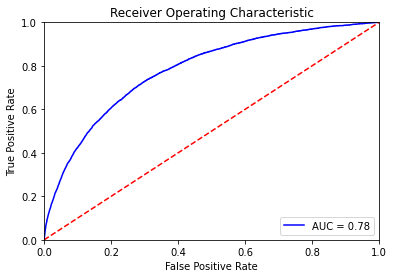

In [54]:
score = lgbmodel.predict_proba(X_val)[:,1]
fpr, tpr, thresholds = roc_curve(y_val, score)
roc_auc = auc(fpr, tpr)

# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

Test Score:	82.5%


              precision    recall  f1-score   support

         0.0       0.95      0.85      0.90     70666
         1.0       0.24      0.53      0.33      6206

    accuracy                           0.82     76872
   macro avg       0.60      0.69      0.61     76872
weighted avg       0.90      0.82      0.85     76872



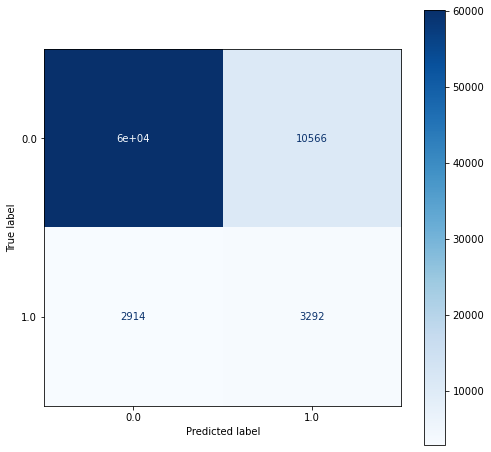

In [55]:
# Confusion Matrix
from sklearn.metrics import plot_confusion_matrix
def model_evaluate(): 
    
    print('Test Score:\t{:0.1f}%'.format(lgbmodel.score(X_val, y_val)*100))
    
    #classification report
    print('\n')
    print(classification_report(y_val, lgbmodel.predict(X_val)))

    #confusion matrix
    

    fig, ax = plt.subplots(figsize=(8, 8))
    confmat = plot_confusion_matrix(lgbmodel, X_val, y_val, cmap=plt.cm.Blues, ax=ax)
    
model_evaluate()

In [56]:
print('Training accuracy {:.4f}'.format(lgbmodel.score(X_train,y_train)))
print('Testing accuracy {:.4f}'.format(lgbmodel.score(X_val,y_val)))

Training accuracy 0.8341
Testing accuracy 0.8246


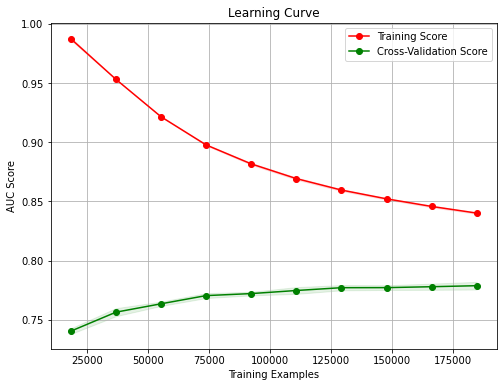

In [87]:
from sklearn.model_selection import learning_curve

def plot_learning_curve(estimator, X_train, y_train):
    train_sizes, train_scores, test_scores = learning_curve(estimator, X_train, y_train, cv=5, scoring='roc_auc', 
                                                            train_sizes=np.linspace(0.1, 1.0, 10))
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    plt.figure(figsize=(8, 6))
    plt.title("Learning Curve")
    plt.xlabel("Training Examples")
    plt.ylabel("AUC Score")
    plt.grid()
    
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1,
                     color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training Score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-Validation Score")
    
    plt.legend(loc="best")
    plt.show()

# Utilisation de la fonction pour tracer la courbe d'apprentissage
plot_learning_curve(lgbmodel, X_train, y_train)

# Feature importance

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

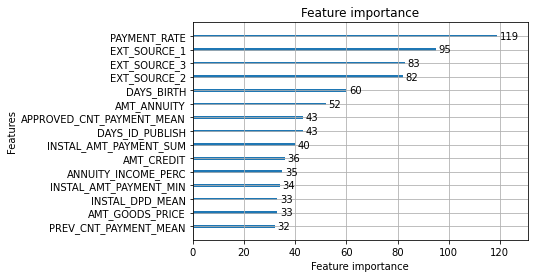

In [121]:
# LGBM plot importance
from lightgbm import plot_importance

plot_importance(lgbmodel, max_num_features=15)

## Shap Global feature importance

In [119]:
explainerlgbm = shap.TreeExplainer(lgbmodel)
shap_values_LightGBM_test = explainerlgbm.shap_values(X_val)
shap_values_LightGBM_train = explainerlgbm.shap_values(X_train)

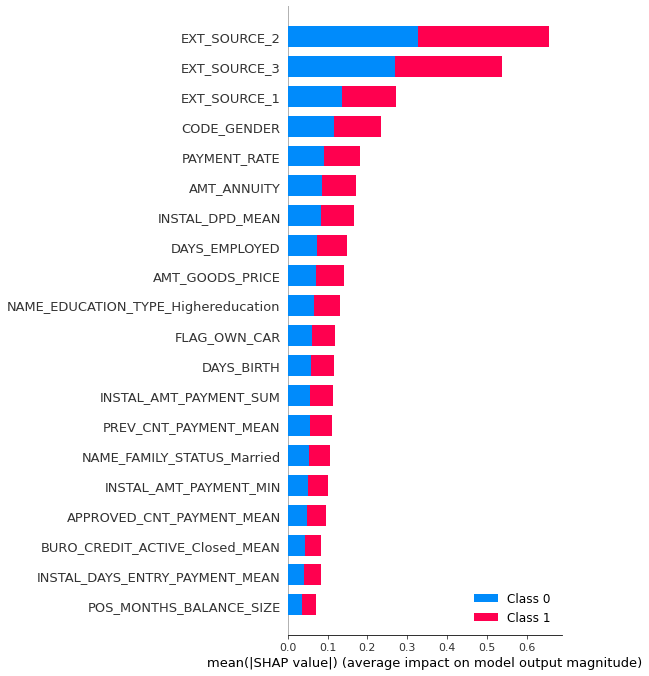

In [59]:
shap.summary_plot(shap_values_LightGBM_train, X_train, plot_type="bar")

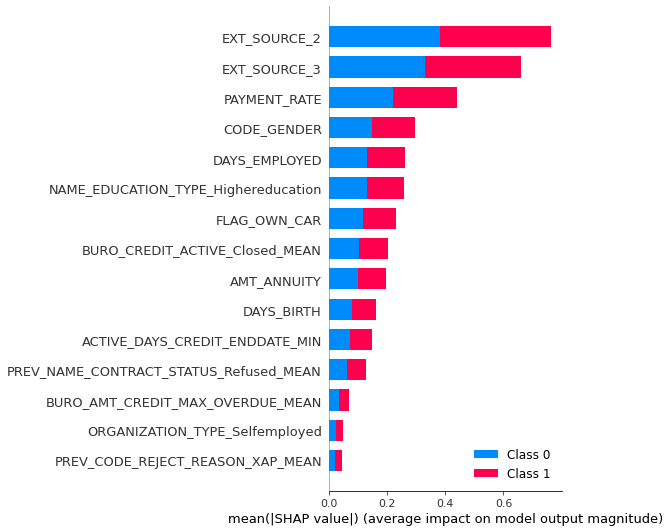

In [176]:
explainerlgbm_10= shap.TreeExplainer(lgbmodel)
shap_values_LightGBM_train_10 = explainerlgbm_10.shap_values(X_train_10)
shap.summary_plot(shap_values_LightGBM_train_10, X_train_10, plot_type="bar")

In [96]:
# Calculer l'importance moyenne pour chaque variable à partir des valeurs SHAP
mean_shap_values = np.abs(shap_values_LightGBM_train).mean(axis=0)

# Trier les variables en fonction de leur importance SHAP
sorted_indices = np.argsort(-mean_shap_values)

# Sélectionner les 10 variables les plus impactantes
top_variables = X_train.columns[sorted_indices[:10]].tolist()

# Afficher les noms des 10 variables les plus impactantes
print(top_variables)


[['EXT_SOURCE_3', 'PREV_NAME_CONTRACT_STATUS_Refused_MEAN', 'EXT_SOURCE_2', 'PAYMENT_RATE', 'AMT_ANNUITY', 'FLAG_OWN_CAR', 'BURO_AMT_CREDIT_MAX_OVERDUE_MEAN', 'DAYS_EMPLOYED', 'DAYS_BIRTH', 'ORGANIZATION_TYPE_Selfemployed', 'CODE_GENDER', 'NAME_EDUCATION_TYPE_Highereducation', 'BURO_CREDIT_ACTIVE_Closed_MEAN', 'ACTIVE_DAYS_CREDIT_ENDDATE_MIN', 'PREV_CODE_REJECT_REASON_XAP_MEAN', 'EXT_SOURCE_1', 'BURO_AMT_CREDIT_SUM_DEBT_MEAN', 'ACTIVE_DAYS_CREDIT_MAX', 'PREV_NAME_CONTRACT_STATUS_Approved_MEAN', 'INSTAL_DPD_MEAN', 'FLAG_DOCUMENT_3', 'AMT_REQ_CREDIT_BUREAU_QRT', 'PREV_APP_CREDIT_PERC_MIN', 'AMT_GOODS_PRICE', 'PREV_NAME_YIELD_GROUP_XNA_MEAN', 'ACTIVE_DAYS_CREDIT_ENDDATE_MEAN', 'POS_MONTHS_BALANCE_SIZE', 'NAME_FAMILY_STATUS_Married', 'DAYS_LAST_PHONE_CHANGE', 'ANNUITY_INCOME_PERC', 'APPROVED_CNT_PAYMENT_MEAN', 'BURO_DAYS_CREDIT_MIN', 'ACTIVE_AMT_CREDIT_SUM_DEBT_MAX', 'PREV_NAME_YIELD_GROUP_low_normal_MEAN', 'PREV_CNT_PAYMENT_MEAN', 'AMT_CREDIT', 'ACTIVE_MONTHS_BALANCE_SIZE_SUM', 'FLAG_WORK

In [131]:
top_10variables = top_variables[0][:15]


In [132]:
top_10variables

['EXT_SOURCE_3',
 'PREV_NAME_CONTRACT_STATUS_Refused_MEAN',
 'EXT_SOURCE_2',
 'PAYMENT_RATE',
 'AMT_ANNUITY',
 'FLAG_OWN_CAR',
 'BURO_AMT_CREDIT_MAX_OVERDUE_MEAN',
 'DAYS_EMPLOYED',
 'DAYS_BIRTH',
 'ORGANIZATION_TYPE_Selfemployed',
 'CODE_GENDER',
 'NAME_EDUCATION_TYPE_Highereducation',
 'BURO_CREDIT_ACTIVE_Closed_MEAN',
 'ACTIVE_DAYS_CREDIT_ENDDATE_MIN',
 'PREV_CODE_REJECT_REASON_XAP_MEAN']

In [108]:
X_train

,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,...,INSTAL_AMT_INSTALMENT_MEAN,INSTAL_AMT_INSTALMENT_SUM,INSTAL_AMT_PAYMENT_MIN,INSTAL_AMT_PAYMENT_MAX,INSTAL_AMT_PAYMENT_MEAN,INSTAL_AMT_PAYMENT_SUM,INSTAL_DAYS_ENTRY_PAYMENT_MAX,INSTAL_DAYS_ENTRY_PAYMENT_MEAN,INSTAL_DAYS_ENTRY_PAYMENT_SUM,INSTAL_COUNT
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
449393,1.0,1.0,0.0,0.0,112500.0,296280.0,16069.5,225000.0,0.035797,-19872.0,...,12572.687500,3.283601e+05,2314.800049,36000.000000,12225.840820,3.186101e+05,-66.0,-807.500,-21127.0,25.0
300253,1.0,0.0,1.0,0.0,112500.0,900000.0,26316.0,900000.0,0.028656,-19856.0,...,19941.652344,3.589498e+05,19691.369141,19956.375000,19941.652344,3.589498e+05,-678.0,-933.000,-16790.0,18.0
330898,1.0,0.0,0.0,1.0,90000.0,204768.0,7717.5,162000.0,0.007332,-12456.0,...,20439.519531,6.131856e+05,11820.509766,138094.468750,20439.519531,6.131856e+05,-25.0,-721.000,-21631.0,30.0
396548,0.0,1.0,0.0,0.0,112500.0,360000.0,25600.5,360000.0,0.005001,-23728.0,...,12254.893555,3.676468e+05,1.620000,15119.190430,9231.399414,2.769420e+05,-113.0,-788.500,-23651.0,30.0
400601,1.0,0.0,0.0,0.0,144000.0,459000.0,20349.0,459000.0,0.010010,-16464.0,...,18133.849609,1.323771e+06,5080.950195,465173.156250,19669.027344,1.435839e+06,-43.0,-800.500,-58425.0,73.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
126275,1.0,0.0,0.0,0.0,112500.0,770292.0,32764.5,688500.0,0.004959,-13968.0,...,18758.287109,2.063412e+05,17225.865234,34082.503906,18758.287109,2.063412e+05,-638.0,-794.000,-8736.0,11.0
156520,0.0,0.0,1.0,1.0,292500.0,298512.0,29655.0,270000.0,0.007019,-17312.0,...,35777.539062,2.719093e+06,298.035004,128231.507812,35497.164062,2.697784e+06,-16.0,-1085.000,-82426.0,76.0
447951,0.0,0.0,1.0,0.0,112500.0,263686.5,28107.0,238500.0,0.006207,-9968.0,...,4590.096680,1.881940e+05,0.450000,13095.000000,4533.451660,1.858715e+05,-20.0,-181.250,-7430.0,41.0


In [133]:
X_train_10 = X_train[top_10variables]
X_val_10 = X_val[top_10variables]

In [134]:
# Recherche des hyperparamètres par cross-validation

classifier = LGBMClassifier(random_state=10)

params = {
    'classifier__learning_rate': [1e-1, 2e-1],
    'classifier__max_depth': [8],
    'classifier__scale_pos_weight': [4, 5, 6, 7],
    'classifier__objective': ['binary'],
    'classifier__subsample': [0.87],
    'classifier__num_leaves': [30]
}


score = {
         'AUC':'roc_auc', 
         'custom':custom_cost
        }

stratified_kfold = StratifiedKFold(n_splits=5,
                                   shuffle=True,
                                   random_state=11,
                                   )

pipeline = Pipeline(steps=[['smote', SMOTE(random_state=1)],
                           ['classifier', classifier]])

gsv = GridSearchCV(pipeline, params, cv=stratified_kfold, scoring='roc_auc', n_jobs = 1,
                         verbose = 10,error_score="raise")
gsv.fit(X_train_10, y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5; 1/8] START classifier__learning_rate=0.1, classifier__max_depth=8, classifier__num_leaves=30, classifier__objective=binary, classifier__scale_pos_weight=4, classifier__subsample=0.87
[CV 1/5; 1/8] END classifier__learning_rate=0.1, classifier__max_depth=8, classifier__num_leaves=30, classifier__objective=binary, classifier__scale_pos_weight=4, classifier__subsample=0.87;, score=0.717 total time=   3.1s
[CV 2/5; 1/8] START classifier__learning_rate=0.1, classifier__max_depth=8, classifier__num_leaves=30, classifier__objective=binary, classifier__scale_pos_weight=4, classifier__subsample=0.87
[CV 2/5; 1/8] END classifier__learning_rate=0.1, classifier__max_depth=8, classifier__num_leaves=30, classifier__objective=binary, classifier__scale_pos_weight=4, classifier__subsample=0.87;, score=0.713 total time=   2.9s
[CV 3/5; 1/8] START classifier__learning_rate=0.1, classifier__max_depth=8, classifier__num_leaves=30, classif

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=11, shuffle=True),
             error_score='raise',
             estimator=Pipeline(steps=[['smote', SMOTE(random_state=1)],
                                       ['classifier',
                                        LGBMClassifier(random_state=10)]]),
             n_jobs=1,
             param_grid={'classifier__learning_rate': [0.1, 0.2],
                         'classifier__max_depth': [8],
                         'classifier__num_leaves': [30],
                         'classifier__objective': ['binary'],
                         'classifier__scale_pos_weight': [4, 5, 6, 7],
                         'classifier__subsample': [0.87]},
             scoring='roc_auc', verbose=10)

In [135]:
gsv.best_score_, gsv.best_params_

(0.7238093500053644,
 {'classifier__learning_rate': 0.2,
  'classifier__max_depth': 8,
  'classifier__num_leaves': 30,
  'classifier__objective': 'binary',
  'classifier__scale_pos_weight': 7,
  'classifier__subsample': 0.87})

In [136]:
gsv.best_estimator_.score(X_val_10, y_val)

0.7119887605369966

In [138]:
lgbmodel = LGBMClassifier(**best_grid.best_params_)
lgbmodel.fit(X_train_10, y_train)

LGBMClassifier(max_depth=8, num_leaves=30, objective='binary',
               scale_pos_weight=7, subsample=0.87)

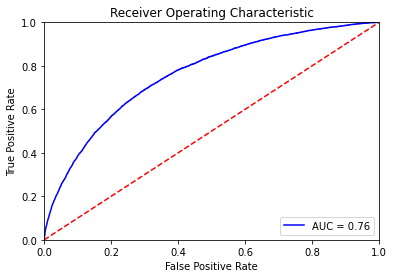

In [139]:
score = lgbmodel.predict_proba(X_val_10)[:,1]
fpr, tpr, thresholds = roc_curve(y_val, score)
roc_auc = auc(fpr, tpr)

# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

Test Score:	81.2%


              precision    recall  f1-score   support

         0.0       0.95      0.84      0.89     70666
         1.0       0.22      0.51      0.30      6206

    accuracy                           0.81     76872
   macro avg       0.58      0.67      0.60     76872
weighted avg       0.89      0.81      0.84     76872



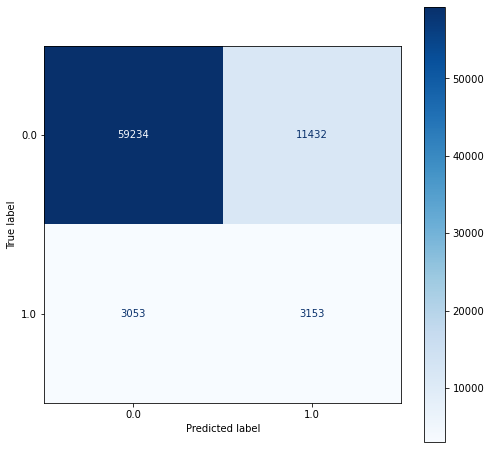

In [140]:
# Confusion Matrix
from sklearn.metrics import plot_confusion_matrix
def model_evaluate(): 
    
    print('Test Score:\t{:0.1f}%'.format(lgbmodel.score(X_val_10, y_val)*100))
    
    #classification report
    print('\n')
    print(classification_report(y_val, lgbmodel.predict(X_val_10)))

    #confusion matrix
    

    fig, ax = plt.subplots(figsize=(8, 8))
    confmat = plot_confusion_matrix(lgbmodel, X_val_10, y_val, cmap=plt.cm.Blues, ax=ax)
    
model_evaluate()

In [141]:
print('Training accuracy {:.4f}'.format(lgbmodel.score(X_train_10,y_train)))
print('Testing accuracy {:.4f}'.format(lgbmodel.score(X_val_10,y_val)))

Training accuracy 0.8161
Testing accuracy 0.8116


In [191]:
df_all_2 = df_all.drop("TARGET", axis=1)

In [193]:
# Calcul des prédictions
pred = lgbmodel.predict(df_all_2)
len(pred)

307488

In [198]:
df_all_2.dtypes

EXT_SOURCE_3                              float16
PREV_NAME_CONTRACT_STATUS_Refused_MEAN    float16
EXT_SOURCE_2                              float16
PAYMENT_RATE                              float16
AMT_ANNUITY                               float32
FLAG_OWN_CAR                              float16
BURO_AMT_CREDIT_MAX_OVERDUE_MEAN          float32
DAYS_EMPLOYED                             float16
DAYS_BIRTH                                float16
ORGANIZATION_TYPE_Selfemployed            float16
CODE_GENDER                               float16
NAME_EDUCATION_TYPE_Highereducation       float16
BURO_CREDIT_ACTIVE_Closed_MEAN            float16
ACTIVE_DAYS_CREDIT_ENDDATE_MIN            float16
PREV_CODE_REJECT_REASON_XAP_MEAN          float16
dtype: object

In [199]:
df_all_2['pred'] = pred

In [201]:
df_all_3 = df_all_2.merge(clean_df["TARGET"], left_index=True, right_index=True)

In [200]:
df_all_2.shape

(307488, 16)

In [202]:
df_all_3.shape

(307488, 17)

In [203]:
df_all_3

,EXT_SOURCE_3,PREV_NAME_CONTRACT_STATUS_Refused_MEAN,EXT_SOURCE_2,PAYMENT_RATE,AMT_ANNUITY,FLAG_OWN_CAR,BURO_AMT_CREDIT_MAX_OVERDUE_MEAN,DAYS_EMPLOYED,DAYS_BIRTH,ORGANIZATION_TYPE_Selfemployed,CODE_GENDER,NAME_EDUCATION_TYPE_Highereducation,BURO_CREDIT_ACTIVE_Closed_MEAN,ACTIVE_DAYS_CREDIT_ENDDATE_MIN,PREV_CODE_REJECT_REASON_XAP_MEAN,pred,TARGET
SK_ID_CURR,,,,,,,,,,,,,,,,,
100002,0.139404,0.000000,0.262939,0.060760,24700.5,0.0,1681.029053,-637.0,-9464.0,0.0,0.0,0.0,0.75000,780.0,1.000000,1.0,1.0
100003,0.535156,0.000000,0.622070,0.027603,35698.5,0.0,0.000000,-1188.0,-16768.0,0.0,1.0,1.0,0.75000,1216.0,1.000000,0.0,0.0
100004,0.729492,0.000000,0.556152,0.049988,6750.0,1.0,0.000000,-225.0,-19040.0,0.0,0.0,0.0,1.00000,252.0,1.000000,0.0,0.0
100006,0.535156,0.111084,0.650391,0.094971,29686.5,0.0,0.000000,-3040.0,-19008.0,0.0,1.0,0.0,0.62500,252.0,0.888672,0.0,0.0
100007,0.535156,0.000000,0.322754,0.042633,21865.5,0.0,0.000000,-3038.0,-19936.0,0.0,0.0,0.0,1.00000,252.0,1.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
456251,0.535156,0.000000,0.681641,0.108215,27558.0,0.0,0.000000,-236.0,-9328.0,0.0,0.0,0.0,0.62500,252.0,1.000000,0.0,0.0
456252,0.535156,0.000000,0.115967,0.044525,12001.5,0.0,0.000000,-1648.0,-20768.0,0.0,1.0,0.0,0.62500,252.0,1.000000,0.0,0.0
456253,0.218872,0.000000,0.535645,0.044250,29979.0,0.0,0.000000,-7920.0,-14968.0,0.0,1.0,1.0,0.50000,387.0,1.000000,0.0,0.0


In [208]:
df_all_3.to_csv('C:\\Users\GOGEO_LAPTOP1\df_all_3.csv')

In [194]:
from evidently import ColumnMapping

In [204]:
column_mapping = ColumnMapping()
column_mapping.target = 'TARGET'
column_mapping.prediction = 'pred' # colonne des prédictions du modèle
column_mapping.id = 'SK_ID_CURR'
column_mapping.datetime = None  # vous pouvez spécifier la colonne contenant la date si nécessaire
column_mapping.numerical_features = ['EXT_SOURCE_3', 'PREV_NAME_CONTRACT_STATUS_Refused_MEAN', 'EXT_SOURCE_2', 'PAYMENT_RATE', 'AMT_ANNUITY', 'BURO_AMT_CREDIT_MAX_OVERDUE_MEAN', 'DAYS_EMPLOYED', 'DAYS_BIRTH']
column_mapping.categorical_features = ['FLAG_OWN_CAR', 'ORGANIZATION_TYPE_Selfemployed', 'CODE_GENDER', 'NAME_EDUCATION_TYPE_Highereducation', 'BURO_CREDIT_ACTIVE_Closed_MEAN', 'PREV_CODE_REJECT_REASON_XAP_MEAN']

In [207]:
pip show evidently

Name: evidently
Version: 0.3.2.1
Summary: Open-source tools to analyze, monitor, and debug machine learning model in production.
Home-page: https://github.com/evidentlyai/evidently
Author: Emeli Dral
Author-email: emeli.dral@gmail.com
License: 
Location: c:\users\gogeo_laptop1\anaconda3\lib\site-packages
Requires: umap-learn, requests, scikit-learn, plotly, PyYAML, pydantic, statsmodels, pandas, nltk, scipy, numpy
Required-by: 
Note: you may need to restart the kernel to use updated packages.


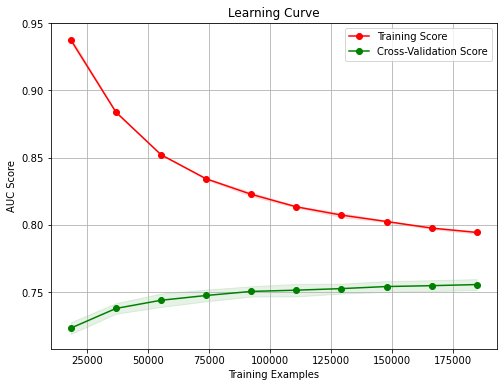

In [143]:
from sklearn.model_selection import learning_curve

def plot_learning_curve(estimator, X_train, y_train):
    train_sizes, train_scores, test_scores = learning_curve(estimator, X_train, y_train, cv=5, scoring='roc_auc', 
                                                            train_sizes=np.linspace(0.1, 1.0, 10))
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    plt.figure(figsize=(8, 6))
    plt.title("Learning Curve")
    plt.xlabel("Training Examples")
    plt.ylabel("AUC Score")
    plt.grid()
    
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1,
                     color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training Score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-Validation Score")
    
    plt.legend(loc="best")
    plt.show()

# Utilisation de la fonction pour tracer la courbe d'apprentissage
plot_learning_curve(lgbmodel, X_train_10, y_train)

In [146]:
clean_df

,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,...,INSTAL_AMT_INSTALMENT_MEAN,INSTAL_AMT_INSTALMENT_SUM,INSTAL_AMT_PAYMENT_MIN,INSTAL_AMT_PAYMENT_MAX,INSTAL_AMT_PAYMENT_MEAN,INSTAL_AMT_PAYMENT_SUM,INSTAL_DAYS_ENTRY_PAYMENT_MAX,INSTAL_DAYS_ENTRY_PAYMENT_MEAN,INSTAL_DAYS_ENTRY_PAYMENT_SUM,INSTAL_COUNT
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100002,1.0,0.0,0.0,0.0,0.0,202500.0,406597.5,24700.5,351000.0,0.018799,...,11559.247070,2.196257e+05,9251.775391,53093.746094,11559.247070,2.196257e+05,-49.0,-315.50,-5993.0,19.0
100003,0.0,1.0,0.0,1.0,0.0,270000.0,1293502.5,35698.5,1129500.0,0.003542,...,64754.585938,1.618865e+06,6662.970215,560835.375000,64754.585938,1.618865e+06,-544.0,-1385.00,-34633.0,25.0
100004,0.0,0.0,1.0,0.0,0.0,67500.0,135000.0,6750.0,135000.0,0.010033,...,7096.154785,2.128846e+04,5357.250000,10573.964844,7096.154785,2.128846e+04,-727.0,-761.50,-2285.0,3.0
100006,0.0,1.0,0.0,0.0,0.0,135000.0,312682.5,29686.5,297000.0,0.008018,...,62947.089844,1.007153e+06,2482.919922,691786.875000,62947.089844,1.007153e+06,-12.0,-271.50,-4346.0,16.0
100007,0.0,0.0,0.0,0.0,0.0,121500.0,513000.0,21865.5,513000.0,0.028656,...,12666.444336,8.359853e+05,0.180000,22678.785156,12214.060547,8.061280e+05,-14.0,-1032.00,-68128.0,66.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
456251,0.0,0.0,0.0,1.0,0.0,157500.0,254700.0,27558.0,225000.0,0.032562,...,7492.924316,5.245047e+04,6605.910156,12815.009766,7492.924316,5.245047e+04,-38.0,-156.25,-1094.0,7.0
456252,0.0,1.0,0.0,0.0,0.0,72000.0,269550.0,12001.5,225000.0,0.025162,...,10069.867188,6.041920e+04,10046.879883,10074.464844,10069.867188,6.041920e+04,-2328.0,-2394.00,-14363.0,6.0
456253,0.0,1.0,0.0,0.0,0.0,153000.0,677664.0,29979.0,585000.0,0.005001,...,4399.708008,6.159591e+04,27.270000,5575.185059,4115.915527,5.762282e+04,-1738.0,-2388.00,-33424.0,14.0


In [156]:
top_10variables.append('TARGET')

In [157]:
top_10variables

['EXT_SOURCE_3',
 'PREV_NAME_CONTRACT_STATUS_Refused_MEAN',
 'EXT_SOURCE_2',
 'PAYMENT_RATE',
 'AMT_ANNUITY',
 'FLAG_OWN_CAR',
 'BURO_AMT_CREDIT_MAX_OVERDUE_MEAN',
 'DAYS_EMPLOYED',
 'DAYS_BIRTH',
 'ORGANIZATION_TYPE_Selfemployed',
 'CODE_GENDER',
 'NAME_EDUCATION_TYPE_Highereducation',
 'BURO_CREDIT_ACTIVE_Closed_MEAN',
 'ACTIVE_DAYS_CREDIT_ENDDATE_MIN',
 'PREV_CODE_REJECT_REASON_XAP_MEAN',
 'TARGET']

In [158]:
df_all = clean_df[top_10variables]
df_all

,EXT_SOURCE_3,PREV_NAME_CONTRACT_STATUS_Refused_MEAN,EXT_SOURCE_2,PAYMENT_RATE,AMT_ANNUITY,FLAG_OWN_CAR,BURO_AMT_CREDIT_MAX_OVERDUE_MEAN,DAYS_EMPLOYED,DAYS_BIRTH,ORGANIZATION_TYPE_Selfemployed,CODE_GENDER,NAME_EDUCATION_TYPE_Highereducation,BURO_CREDIT_ACTIVE_Closed_MEAN,ACTIVE_DAYS_CREDIT_ENDDATE_MIN,PREV_CODE_REJECT_REASON_XAP_MEAN,TARGET
SK_ID_CURR,,,,,,,,,,,,,,,,
100002,0.139404,0.000000,0.262939,0.060760,24700.5,0.0,1681.029053,-637.0,-9464.0,0.0,0.0,0.0,0.75000,780.0,1.000000,1.0
100003,0.535156,0.000000,0.622070,0.027603,35698.5,0.0,0.000000,-1188.0,-16768.0,0.0,1.0,1.0,0.75000,1216.0,1.000000,0.0
100004,0.729492,0.000000,0.556152,0.049988,6750.0,1.0,0.000000,-225.0,-19040.0,0.0,0.0,0.0,1.00000,252.0,1.000000,0.0
100006,0.535156,0.111084,0.650391,0.094971,29686.5,0.0,0.000000,-3040.0,-19008.0,0.0,1.0,0.0,0.62500,252.0,0.888672,0.0
100007,0.535156,0.000000,0.322754,0.042633,21865.5,0.0,0.000000,-3038.0,-19936.0,0.0,0.0,0.0,1.00000,252.0,1.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
456251,0.535156,0.000000,0.681641,0.108215,27558.0,0.0,0.000000,-236.0,-9328.0,0.0,0.0,0.0,0.62500,252.0,1.000000,0.0
456252,0.535156,0.000000,0.115967,0.044525,12001.5,0.0,0.000000,-1648.0,-20768.0,0.0,1.0,0.0,0.62500,252.0,1.000000,0.0
456253,0.218872,0.000000,0.535645,0.044250,29979.0,0.0,0.000000,-7920.0,-14968.0,0.0,1.0,1.0,0.50000,387.0,1.000000,0.0


In [159]:
df_all.to_csv('C:\\Users\GOGEO_LAPTOP1\df_all.csv')

In [160]:
pd.read_csv('C:\\Users\GOGEO_LAPTOP1\df_all.csv',index_col='SK_ID_CURR')

,EXT_SOURCE_3,PREV_NAME_CONTRACT_STATUS_Refused_MEAN,EXT_SOURCE_2,PAYMENT_RATE,AMT_ANNUITY,FLAG_OWN_CAR,BURO_AMT_CREDIT_MAX_OVERDUE_MEAN,DAYS_EMPLOYED,DAYS_BIRTH,ORGANIZATION_TYPE_Selfemployed,CODE_GENDER,NAME_EDUCATION_TYPE_Highereducation,BURO_CREDIT_ACTIVE_Closed_MEAN,ACTIVE_DAYS_CREDIT_ENDDATE_MIN,PREV_CODE_REJECT_REASON_XAP_MEAN,TARGET
SK_ID_CURR,,,,,,,,,,,,,,,,
100002,0.13940,0.0000,0.26300,0.06076,24700.5,0.0,1681.029,-637.0,-9464.0,0.0,0.0,0.0,0.7500,780.0,1.0000,1.0
100003,0.53500,0.0000,0.62200,0.02760,35698.5,0.0,0.000,-1188.0,-16770.0,0.0,1.0,1.0,0.7500,1216.0,1.0000,0.0
100004,0.72950,0.0000,0.55600,0.05000,6750.0,1.0,0.000,-225.0,-19040.0,0.0,0.0,0.0,1.0000,252.0,1.0000,0.0
100006,0.53500,0.1111,0.65040,0.09500,29686.5,0.0,0.000,-3040.0,-19000.0,0.0,1.0,0.0,0.6250,252.0,0.8887,0.0
100007,0.53500,0.0000,0.32280,0.04263,21865.5,0.0,0.000,-3038.0,-19940.0,0.0,0.0,0.0,1.0000,252.0,1.0000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
456251,0.53500,0.0000,0.68160,0.10820,27558.0,0.0,0.000,-236.0,-9330.0,0.0,0.0,0.0,0.6250,252.0,1.0000,0.0
456252,0.53500,0.0000,0.11597,0.04453,12001.5,0.0,0.000,-1648.0,-20770.0,0.0,1.0,0.0,0.6250,252.0,1.0000,0.0
456253,0.21890,0.0000,0.53560,0.04425,29979.0,0.0,0.000,-7920.0,-14970.0,0.0,1.0,1.0,0.5000,387.0,1.0000,0.0


# Déploiement du modèle

In [161]:
# serialization
import pickle
pickle_out = open("models/classifier.pkl","wb")
pickle.dump(lgbmodel, pickle_out)
pickle_out.close()

In [163]:
print("Nombre de variables attendu par le modèle :", lgbmodel.n_features_in_)

Nombre de variables attendu par le modèle : 15
